In [58]:
import os
mingw_path = 'g:/mingw64/bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
#import xgboost as xgb

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from haversine import haversine
import datetime as dt

from subprocess import check_output

In [30]:
#load training data
trainDF = pd.read_csv("train.csv")

# Load testing data
testDF = pd.read_csv("test.csv")

# Print size as well as the top 5 observation of training dataset
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", trainDF.head(5))

Size of the training set is: 1458644 rows and 11 columns

           id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.

In [31]:
# Look at the summary of numerical variables for train data set
df = trainDF.describe()
print (df)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

In [32]:
# Print the shape of the data
print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

Train shape :  (1458644, 11)
Test shape :  (625134, 9)


In [33]:
dtypeDF = trainDF.dtypes.reset_index()
dtypeDF.columns = ["Count", "Column Type"]
dtypeDF.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3
1,float64,4
2,object,4


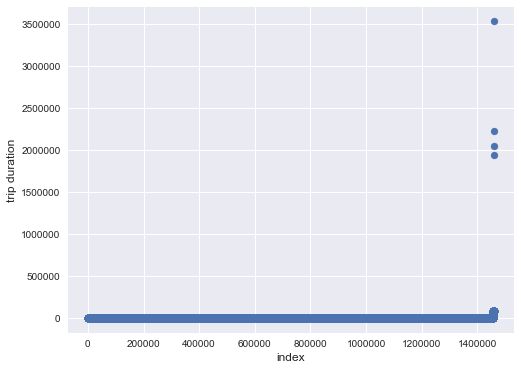

In [11]:
# Plot the trip duration
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

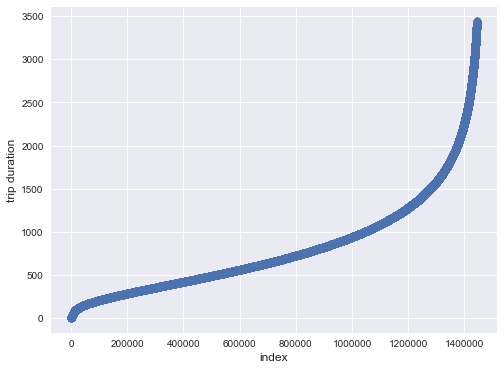

In [34]:
# in train dataset some trip duration are very high (I consider them outliers and remove them before replotting it)
th = trainDF.trip_duration.quantile(0.99)
tempDF = trainDF
tempDF = tempDF[tempDF['trip_duration'] < th]
plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]), np.sort(tempDF.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

del tempDF

In [35]:
# Lets remove the outliers from the train data target
trainDF = trainDF[trainDF['trip_duration'] < th]

In [36]:
# Number of variables with missing values
variables_missing_value = trainDF.isnull().sum()
variables_missing_value 

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [37]:
variables_missing_value = testDF.isnull().sum()
variables_missing_value 

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [39]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()

train = trainDF
test = testDF
del trainDF, testDF

In [48]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

train['trip_duration'].describe()
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [63]:
# Feature Extraction

#combining test & training datapoints + vertically stacking pickup and dropoff latitude
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)

#Include 2 principal components for pick up and drop off location
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]


In [65]:
# Distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [78]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']


train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)



In [88]:
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))

test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))




In [94]:
feature_names = list(train.columns)

do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [96]:
print (feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour']
We have 20 features.


vendor_id                 1444051
passenger_count           1444051
pickup_longitude          1444051
pickup_latitude           1444051
dropoff_longitude         1444051
dropoff_latitude          1444051
store_and_fwd_flag        1444051
pickup_pca0               1444051
pickup_pca1               1444051
dropoff_pca0              1444051
dropoff_pca1              1444051
distance_haversine        1444051
center_latitude           1444051
center_longitude          1444051
pickup_weekday            1444051
pickup_hour_weekofyear    1444051
pickup_hour               1444051
pickup_minute             1444051
pickup_dt                 1444051
pickup_week_hour          1444051
dtype: int64

In [99]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=9, verbosity=2)
#from sklearn.model_selection import train_test_split

OSError: [WinError 126] The specified module could not be found

In [100]:
# K Fold Cross Validation
from sklearn.model_selection import KFold

X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1)  


kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)  

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 144406  144407  144408 ..., 1444048 1444049 1444050] TEST: [     0      1      2 ..., 144403 144404 144405]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [144406 144407 144408 ..., 288808 288809 288810]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [288811 288812 288813 ..., 433213 433214 433215]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [433216 433217 433218 ..., 577618 577619 577620]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [577621 577622 577623 ..., 722023 722024 722025]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [722026 722027 722028 ..., 866428 866429 866430]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [ 866431  866432  866433 ..., 1010833 1010834 1010835]
TRAIN: [      0       1       2 ..., 1444048 1444049 1444050] TEST: [1010836 1010837 1010838 ..., 1155238 1155239 1155240]

In [112]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

In [116]:
x_sample = X_train[0:50000]
y_sample = y_train[0:50000]

In [117]:
rf_model.fit(x_sample, y_sample)
predictions=rf_model.predict(test[feature_names].values)
predictions[:5]

array([ 6.69341419,  6.52380013,  6.04251496,  7.08906446,  5.77199306])

In [ ]:
print (X_train.shape)


rf_model.fit(X_train, y_train)
predictions=rf_model.predict(test.values)
predictions[:5]